In [1]:
#Plotting
%matplotlib inline
from matplotlib import style
style.use("fivethirtyeight")
import matplotlib.pyplot as plt

In [2]:
#Data manipulation
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
#Python SQL Toolkit and ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
#Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
#New base class
Base = automap_base()

#Reflect the tables from the hawaii.sqlite database
Base.prepare(engine)

In [6]:
#View classes found by automap
Base.classes.keys()

['measurement', 'station']

In [7]:
#Class references
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
#Link Python to the database by creating a SQLAlchemy session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#Preview the first row of the measurement table
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x20d333da530>,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'date': '2010-01-01'}

In [10]:
#Find the most recent date in the dataset
date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
date_query

('2017-08-23',)

In [11]:
# Convert the most recent date to a datetime object.
for date in date_query:
    latest_date = pd.to_datetime(date)

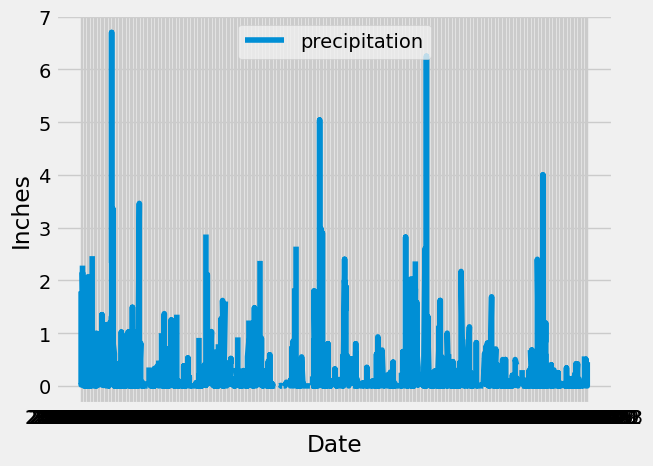

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date_one_year_ago = dt.date(latest_date.year-1,latest_date.month,latest_date.day)

# Perform a query to retrieve the data and precipitation scores
one_year = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= date_one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
one_year_df = pd.DataFrame(one_year)
one_year_df.rename(columns={"date":"Date","prcp":"Precipitation"},inplace=True)

# Sort the dataframe by date
one_year_df.sort_values(by="Date",ascending=True,inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
x = one_year_df["Date"]
y = one_year_df["Precipitation"]
plt.plot(x,y)
plt.xlabel("Date")
plt.ylabel("Inches")
#plt.xticks(np.arange(min(x), max(x)+1, 1.0),rotation=90)
plt.legend(["precipitation"],loc="upper center")
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
one_year_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
#Preview the first row of the station table
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x20d334b7550>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0}

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()
total_stations

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count('*').label('station')).group_by(Measurement.station).order_by(func.count('*').desc())
for row in most_active_stations:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station, func.count(Measurement.station)).\
                      group_by(Measurement.station).order_by(func.count(Measurement.station).\
                      desc()).first()[0]
most_active_station_summary = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                              group_by(Measurement.station).filter(Measurement.station==most_active_station)
for row in most_active_station_summary:
    print(row)

(54.0, 85.0, 71.66378066378067)


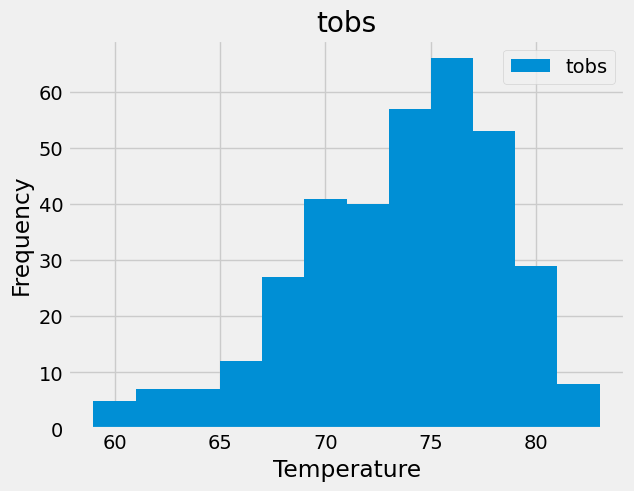

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
rain = session.query(Measurement.date,Measurement.tobs).\
       filter(Measurement.date >= date_one_year_ago).\
       filter(Measurement.station==most_active_station).all()

rain_df = pd.DataFrame(rain)

rain_df.hist(bins=12)
plt.legend(["tobs"])
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [19]:
# Close Session
session.close()